# 1 - NER PyTorch


**Sources** :
- Source de données Kaggle : https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus
- Tuto Abishek : https://www.youtube.com/watch?v=MqQ7rqRllIc

**TODO**
- [ ] changer le padding par une autre valeur
- [x] set num workers (minitrain, valid et test)
- [ ] peut-on monter la taille des batchs ?
- [ ] vérifier que le code <a href="https://www.kaggle.com/code/abhishek/entity-extraction-model-using-bert-pytorch">ici</a> est le bon
- [ ] enregistrer la running loss
- [ ] gradual unfreezing
- [ ] early stopping avec lightning
- [ ] wandb

In [1]:
%load_ext autoreload
%autoreload 2

import os
import time

import joblib
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import get_linear_schedule_with_warmup

os.chdir('..')

from ner_pytorch.config.params import PARAMS
from ner_pytorch.dataset import EntityDataset
from ner_pytorch.engine import eval_fn, train_fn
from ner_pytorch.model import EntityModel
from ner_pytorch.preprocessing import process_data
from ner_pytorch.utils import *

## Chargement des données

In [2]:
data = pd.read_csv(PARAMS.PATHS.TRAIN, encoding='latin-1').drop('POS', axis=1)
data["Sentence #"] = data["Sentence #"].fillna(method='ffill')
data.head(7)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo


En réalité, nous ne nous intéressons qu'à la prédiction des ORG, pour lesquelles 3 labels sont possibles :
- B-org
- I-org
- O

In [3]:
data['Tag'] = data.Tag.mask(~data.Tag.isin(['B-org', 'I-org', 'O']), 'O')
data.Tag.value_counts(normalize=True)

O        0.964784
B-org    0.019210
I-org    0.016006
Name: Tag, dtype: float64

In [4]:
num_tag = data.Tag.nunique()
print(f'Tag {num_tag} categories :', data.Tag.unique(), end='\n\n')

data.shape
data[153:160]

Tag 3 categories : ['O' 'B-org' 'I-org']



(1048575, 3)

,Sentence #,Word,Tag
153,Sentence: 8,The,O
154,Sentence: 8,International,B-org
155,Sentence: 8,Atomic,I-org
156,Sentence: 8,Energy,I-org
157,Sentence: 8,Agency,I-org
158,Sentence: 8,is,O
159,Sentence: 8,to,O


In [5]:
sentences, tag, label_enc_NER = process_data(data)
joblib.dump(label_enc_NER, 'data/outputs/label_enc_NER.joblib')

['data/outputs/label_enc_NER.joblib']

In [6]:
# Démo : 
i = 10
print(sentences[i], end='\n')
print(tag[i], end='\n')
print(label_enc_NER.classes_, end='\n')

['In', 'Beirut', ',', 'a', 'string', 'of', 'officials', 'voiced', 'their', 'anger', ',', 'while', 'at', 'the', 'United', 'Nations', 'summit', 'in', 'New', 'York', ',', 'Prime', 'Minister', 'Fouad', 'Siniora', 'said', 'the', 'Lebanese', 'people', 'are', 'resolute', 'in', 'preventing', 'such', 'attempts', 'from', 'destroying', 'their', 'spirit', '.']
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
['B-org' 'I-org' 'O']


## Split du jeu de données
On split notre jeu de données de la façon suivante :
- `test` = 20%
- `train` = [`minitrain`, `valid`] = 80%
- `minitrain` = 60%
- `valid` = 20%

In [7]:
len_test = int(PARAMS.SAMPLE_SIZES.TEST * len(sentences))
len_valid = int(PARAMS.SAMPLE_SIZES.VALID * len(sentences))

(
    sentences_train, sentences_test,
    tag_train, tag_test
) = train_test_split(sentences, tag, random_state=PARAMS.SEED, 
                     test_size=len_test)

(
    sentences_minitrain, sentences_valid,
    tag_minitrain, tag_valid
) = train_test_split(sentences_train, tag_train, 
                     random_state=PARAMS.SEED, test_size=len_valid)

len(sentences_minitrain), len(sentences_valid), len(sentences_test)

(28777, 9591, 9591)

In [8]:
minitrain_dataset = EntityDataset(
    texts=sentences_minitrain, tags=tag_minitrain
)
minitrain_data_loader = DataLoader(
    minitrain_dataset, batch_size=PARAMS.MODEL.TRAIN_BATCH_SIZE, num_workers=16 
)

valid_dataset = EntityDataset(
    texts=sentences_valid, tags=tag_valid
)
valid_data_loader = DataLoader(
    valid_dataset, batch_size=PARAMS.MODEL.VALID_BATCH_SIZE, num_workers=16
)

test_dataset = EntityDataset(
    texts=sentences_test, tags=tag_test
)
test_data_loader = DataLoader(
    test_dataset, batch_size=PARAMS.MODEL.VALID_BATCH_SIZE, num_workers=16
)

In [10]:
i = 2
print(test_dataset.texts[i])
for key, value in test_dataset[i].items():
    print(key + ':', value)

['The', 'Defense', 'Department', 'is', 'investigating', 'the', 'accusations', '.']
ids: tensor([  101,  1996,  3639,  2533,  2003, 11538,  1996, 13519,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     

## Expériences pré-entraînement

Avant de lancer le modèle, quelle _loss_ serait considérée comme statisfaisante ? Calculons à l'avance les loss que donneraient :

- un modèle qui prédit aléatoirement 
- un modèle qui prédit la classe modale ("O")
- un modèle qui prédit de façon satisfaisante
- un modèle oracle (prédiction parfaite)


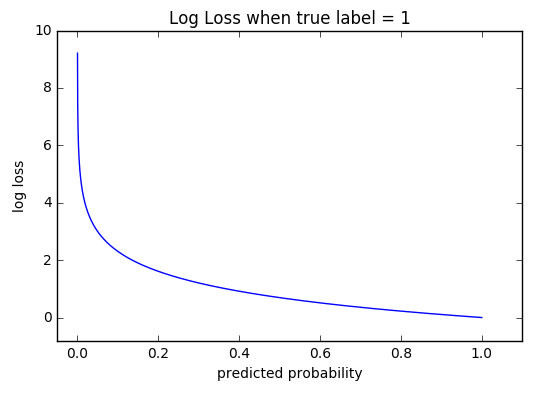

In [11]:
loss_ce = nn.CrossEntropyLoss()
y_true = torch.tensor(label_enc_NER.transform(data.Tag), dtype=torch.long)  # sans le +1 ici !
y_true_ohe = torch.tensor(
    pd.get_dummies(y_true).astype(float).replace(0, -1234).to_numpy(),
    dtype=torch.float
)

In [12]:
#  Modèle oracle :
y_pred = y_true_ohe
print('Loss oracle :', loss_ce(y_pred, y_true))

# Modèle avec une accuracy de 98 %
# Pour rappel, une accuracy en dessous de 96 % est mauvaise !
# → data.Tag.value_counts(normalize=True)
accuracy_souhaitée = 0.98
nb_lignes_à_erroring = int((1 - accuracy_souhaitée) * y_true.shape[0])
y_pred = y_true_ohe.detach()
y_pred[0:nb_lignes_à_erroring, :] = y_pred[0:nb_lignes_à_erroring, :].flip(1)  # smart ! 
print("Loss d'un modèle satisfaisant :", loss_ce(y_pred, y_true))

# Modèle qui prédit la classe modale : 
classe_modale = data.Tag.value_counts().nlargest(1).index[0]
y_pred = np.full((len(data), num_tag), -1234)
y_pred[:, label_enc_NER.transform([classe_modale])[0]] = 1
y_pred = torch.tensor(y_pred, dtype=torch.float)
print("Loss du modèle qui prédit argcount :", loss_ce(y_pred, y_true))

# Modèle aléatoire :
y_pred = torch.tensor(
    pd.get_dummies(torch.randint(0, num_tag, (len(data),))).astype(float).replace(0, -1234).to_numpy(),
    dtype=torch.float
)
print("Loss d'un modèle aléatoire :", loss_ce(y_pred, y_true))

Loss oracle : tensor(0.)
Loss d'un modèle satisfaisant : tensor(24.3661)
Loss du modèle qui prédit argcount : tensor(43.4922)
Loss d'un modèle aléatoire : tensor(822.9234)


## Modélisation

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [14]:
model = EntityModel(num_tag=num_tag)
model.to(device);

Some weights of the model checkpoint at data/inputs/models/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

In [16]:
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

In [17]:
num_train_steps = int(len(sentences_minitrain) / PARAMS.MODEL.TRAIN_BATCH_SIZE * PARAMS.MODEL.EPOCHS)
print(f"{num_train_steps} batchs vont être envoyés dans le réseau au cours de {PARAMS.MODEL.EPOCHS} epochs.")

optimizer = torch.optim.AdamW(optimizer_parameters, lr=PARAMS.MODEL.LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)

2248 batchs vont être envoyés dans le réseau au cours de 5 epochs.


In [18]:
for temp in minitrain_data_loader:
    break

temp

{'ids': tensor([[  101,  2720,  1012,  ...,     0,     0,     0],
         [  101,  1057,  1012,  ...,     0,     0,     0],
         [  101,  4584,  1997,  ...,     0,     0,     0],
         ...,
         [  101,  1996,  2457,  ...,     0,     0,     0],
         [  101,  1037, 14056,  ...,     0,     0,     0],
         [  101,  3956,  2701,  ...,     0,     0,     0]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'target_tag': tensor([[0, 2, 2,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 2, 2,  ..., 0, 0, 0],
         ...,
         [0,

## Entraînement

In [34]:
best_loss = np.inf

pbar = tqdm(range(PARAMS.MODEL.EPOCHS))
for num_epoch, epoch in enumerate(pbar):
    train_loss = train_fn(minitrain_data_loader, model, optimizer, 
                          device, scheduler, pbar=pbar, num_epoch=num_epoch)
    
    # On évalue le modèle à la fin de chaque epoch
    test_loss = eval_fn(valid_data_loader, model, device)
    print(f"Train Loss = {train_loss} Valid Loss = {test_loss}")
    
    if test_loss < best_loss:
        torch.save(model.state_dict(), PARAMS.PATHS.MODEL_SAVED)
        best_loss = test_loss

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Prédictions

In [177]:
i = 2
single_example = test_dataset[i]
print(' '.join(test_dataset.texts[i]))
nb_tokens = test_dataset[i]['mask'].sum().item()

single_example = {k: single_example[k].unsqueeze(0) for k in single_example}
output, loss = model(**single_example)
predictions_probas = nn.functional.softmax(output, dim=2).detach().squeeze()
predictions_probas, predictions_classes = torch.max(predictions_probas, dim=1)

The Defense Department is investigating the accusations .


In [178]:
ids = single_example['ids'].squeeze()[:nb_tokens]
pd.DataFrame({
    'token_id': ids,
    'token_text': [EntityDataset.tokenizer.decode([token]) for token in ids],
    'class_code': predictions_classes[:nb_tokens],
    'class_label': label_enc_NER.inverse_transform(predictions_classes)[:nb_tokens],
    'class_proba': predictions_probas[:nb_tokens]
})

,token_id,token_text,class_code,class_label,class_proba
0,101,[CLS],2,O,0.417185
1,1996,the,1,I-org,0.450611
2,3639,defense,0,B-org,0.417279
3,2533,department,0,B-org,0.520353
4,2003,is,0,B-org,0.470701
5,11538,investigating,0,B-org,0.539455
6,1996,the,1,I-org,0.614620
7,13519,accusations,2,O,0.436867
8,1012,.,2,O,0.369892
9,102,[SEP],1,I-org,0.435651
